In [1]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
def extract_features(file_path, mfcc=True, chroma=True, mel=True):
    with open(file_path, 'rb') as f:
        audio, sr = librosa.load(file_path, sr=None)
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        stft = np.abs(librosa.stft(audio))
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sr).T, axis=0)
        result = np.hstack((result, mel))
    return result


In [3]:
def load_data(data_directory):
    labels = []
    features = []
    for label in os.listdir(data_directory):
        if label.startswith('.'):
            continue
        for file in os.listdir(os.path.join(data_directory, label)):
            file_path = os.path.join(data_directory, label, file)
            feature = extract_features(file_path)
            features.append(feature)
            labels.append(label)
    return np.array(features), np.array(labels)


dataset_directory = r'D:\dataset\Dataset'
features, labels = load_data(dataset_directory)

In [4]:
encoder = LabelEncoder()
encoder.fit(labels)
encoded_labels = encoder.transform(labels)
num_classes = len(encoder.classes_)

X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)


In [5]:
import joblib
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))  # Correct usage of Input layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


from keras.callbacks import EarlyStopping



Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6290 - loss: 0.8337 - val_accuracy: 0.9270 - val_loss: 0.2629
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8907 - loss: 0.2909 - val_accuracy: 0.9213 - val_loss: 0.2070
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9407 - loss: 0.1826 - val_accuracy: 0.9438 - val_loss: 0.1542
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9545 - loss: 0.1747 - val_accuracy: 0.9438 - val_loss: 0.1424
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9510 - loss: 0.1476 - val_accuracy: 0.9551 - val_loss: 0.1061
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9647 - loss: 0.1226 - val_accuracy: 0.9663 - val_loss: 0.0953
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9702 - loss: 0.0956 - val_accuracy: 0.9719 - val_loss: 0.0857
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9681 - loss: 0.1076 - val_accuracy: 0.9719 - val_los

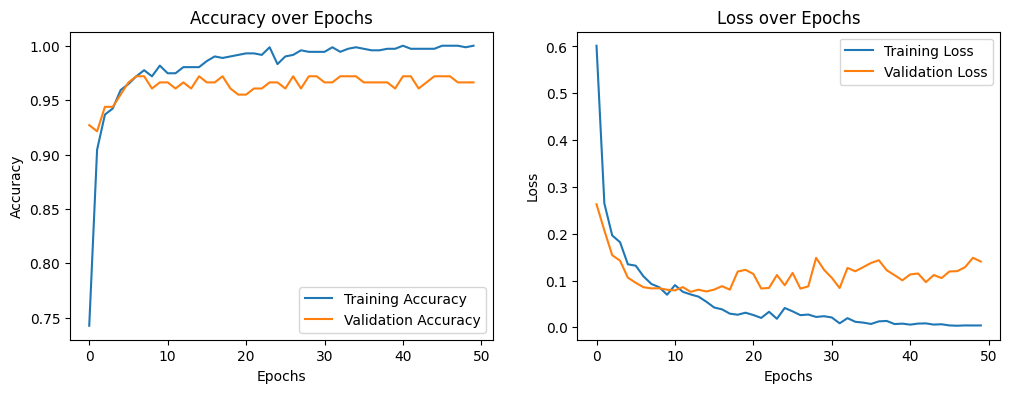

Scaler saved successfully.
Label encoder classes saved successfully.


In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy on test set: {accuracy * 100:.2f}%')

predictions = model.predict(X_test)
  
model.save('my_model.keras')
y_pred = np.argmax(predictions, axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()

try:
    joblib.dump(scaler, 'scaler.save')
    print("Scaler saved successfully.")
except Exception as e:
    print(f"Error saving scaler: {e}")

# Save the label encoder classes
try:
    np.save('classes.npy', encoder.classes_)
    print("Label encoder classes saved successfully.")
except Exception as e:
    print(f"Error saving label encoder classes: {e}")



Scaler loaded successfully


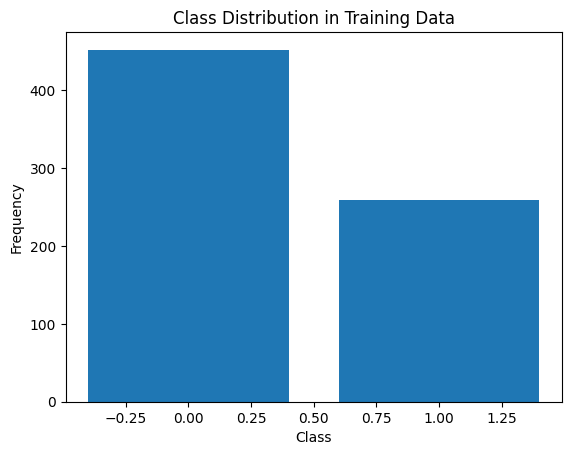

In [8]:
import joblib

# Load the scaler
try:
    scaler = joblib.load('C:\\Users\\kdeep\\CRY\\scaler.save')  # Ensure this path is correct and the file exists
    print("Scaler loaded successfully")
except Exception as e:
    print(f"Error saving scaler: {e}")


import numpy as np
import matplotlib.pyplot as plt

# Assuming y_train contains the labels
classes, counts = np.unique(y_train, return_counts=True)
plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Data')
plt.show()
